In [1]:
import os
import joblib
from tqdm import tqdm
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Transformer

### Data Importing

In [3]:
df = pd.read_csv("./.data/train_aug.csv")

In [4]:
print(df)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.094944  3.205389  3.313624  3.339701  3.361018  3.379836   
1           p01_1  3.340175  3.361399  3.380423  3.339701  3.294160  3.246258   
2           p01_2  3.340175  3.294538  3.246826  3.172513  3.093589  3.012496   
3           p01_3  3.172972  3.093953  3.013033  3.038763  3.060160  3.079285   
4           p01_4  3.039210  3.060522  3.079831  3.061055  3.037874  3.012496   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.156654 -0.156741 -0.210417 -0.177942 -0.285088 -0.383573   
354044  p12_25295 -0.153169 -0.205252 -0.177643 -0.291374 -0.403435 -0.453188   
354045  p12_25296 -0.182927 -0.187252 -0.292545 -0.392158 -0.450797 -0.517543   
354046  p12_25297 -0.197369 -0.276990 -0.399657 -0.454536 -0.553658 -0.620565   
354047  p12_25298 -0.285812 -0.385110 -0.459777 -0.539657 -0.641673 -0.682555   

         bg-1:25   bg-1:20 

In [5]:
for col in df.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

### Data Splitting

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (283238, 146)
Validation Shape: (35405, 146)
Test Shape: (35405, 146)


### Dataset and DataLoader

In [8]:
class BrisT1DDataset(Dataset):
    def __init__(self, df, is_train=True):
        
        self.df = df
        self.is_train = is_train
        
        if 'id' in self.df.columns:
            self.ids = self.df['id'].values
            self.df = self.df.drop(columns=['id'])
        else:
            self.ids = None
        
        if self.is_train and 'bg+1:00' in self.df.columns:
            self.targets = self.df['bg+1:00'].values
            self.df = self.df.drop(columns=['bg+1:00'])
        else:
            self.targets = None
        
        data = self.df.values.astype(np.float32)
        if data.shape[1] != 144:
            raise ValueError(f"Expected 144, Real {data.shape[1]}")
        self.X = data.reshape(-1, 6, 24).transpose(0, 2, 1)
        
        if self.is_train:
            self.y = self.targets.astype(np.float32).reshape(-1, 1)
        else:
            self.y = None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.is_train:
            target = torch.tensor(self.y[idx], dtype=torch.float32)
            return sample, target
        else:
            return sample

In [9]:
train_dataset = BrisT1DDataset(train_df, is_train=True)
val_dataset = BrisT1DDataset(val_df, is_train=True)
test_dataset = BrisT1DDataset(test_df, is_train=True)

In [10]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [11]:
class BrisT1DDPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.25, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [12]:
class BrisT1DDTransformer(nn.Module):
    def __init__(self, num_features=6, d_model=64, nhead=8, num_layers=2, dropout=0.25, seq_length=24):
        super().__init__()
        self.input_projection = nn.Linear(num_features, d_model)
        self.positional_encoding = BrisT1DDPositionalEncoding(d_model, dropout, max_len=seq_length)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.input_projection(x)            
        x = self.positional_encoding(x)           
        x = self.transformer_encoder(x)           
        x = x.mean(dim=1)                        
        x = self.dropout(x)
        out = self.fc(x)                        
        return out

In [13]:
model = BrisT1DDTransformer(num_features=6, d_model=64, nhead=8, num_layers=2,
                            dropout=0.25, seq_length=24).to(device)
print(model)

BrisT1DDTransformer(
  (input_projection): Linear(in_features=6, out_features=64, bias=True)
  (positional_encoding): BrisT1DDPositionalEncoding(
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=

#### Model Summary

In [14]:
dummy_seq = torch.randn(1, 24, 6).to(device)

In [15]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                        Output Shape              Param #
BrisT1DDTransformer                           [1, 1]                    --
├─Linear: 1-1                                 [1, 24, 64]               448
├─BrisT1DDPositionalEncoding: 1-2             [1, 24, 64]               --
│    └─Dropout: 2-1                           [1, 24, 64]               --
├─TransformerEncoder: 1-3                     [1, 24, 64]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 24, 64]               281,152
│    │    └─TransformerEncoderLayer: 3-2      [1, 24, 64]               281,152
├─Dropout: 1-4                                [1, 64]                   --
├─Linear: 1-5                                 [1, 1]                    65
Total params: 562,817
Trainable params: 562,817
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass si

#### Model Computational Graph

In [16]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


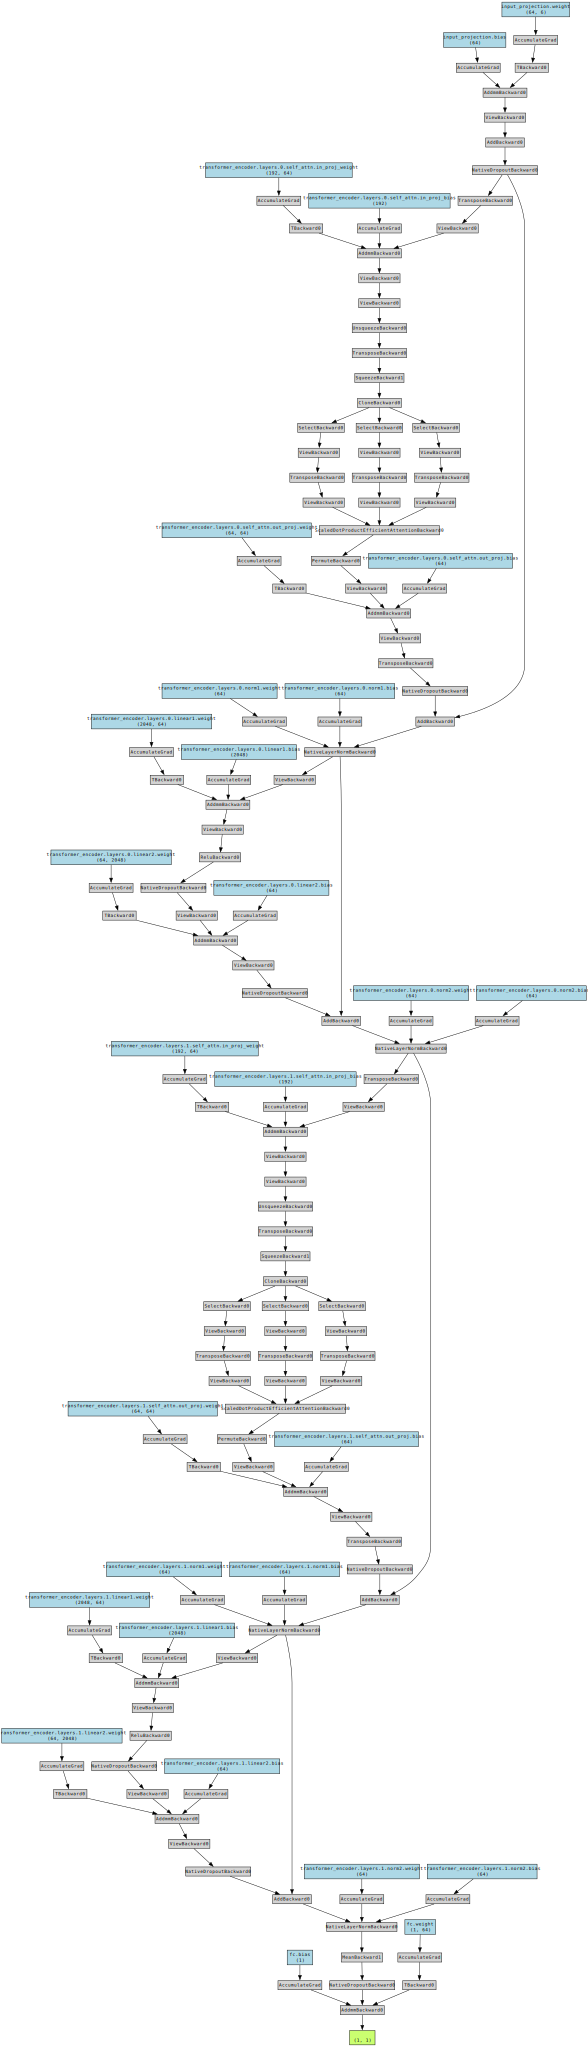

In [17]:
print("Model Computational Graph:")
display(dot)

### Training

In [18]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
patience = 10

In [19]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

In [20]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    # Training
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            running_val_loss += loss.item() * X_val.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), './.export/checkpoint-aug-tf.pt')
    else:
        epochs_no_improve += 1
        print(f"Early Stopping: {epochs_no_improve}/{patience}")
        
    if epochs_no_improve >= patience:
        print("Early Stopping!")
        break

Epoch: 1/100 | Train Loss: 0.5428 | Val Loss: 0.4766


Epoch: 2/100 | Train Loss: 0.4786 | Val Loss: 0.4395


Epoch: 3/100 | Train Loss: 0.4666 | Val Loss: 0.4504
Early Stopping: 1/10


Epoch: 4/100 | Train Loss: 0.4581 | Val Loss: 0.4364


Epoch: 5/100 | Train Loss: 0.4535 | Val Loss: 0.4285


Epoch: 6/100 | Train Loss: 0.4482 | Val Loss: 0.4209


Epoch: 7/100 | Train Loss: 0.4446 | Val Loss: 0.4253
Early Stopping: 1/10


Epoch: 8/100 | Train Loss: 0.4408 | Val Loss: 0.4229
Early Stopping: 2/10


Epoch: 9/100 | Train Loss: 0.4351 | Val Loss: 0.4137


Epoch: 10/100 | Train Loss: 0.4317 | Val Loss: 0.4054


Epoch: 11/100 | Train Loss: 0.4300 | Val Loss: 0.4228
Early Stopping: 1/10


Epoch: 12/100 | Train Loss: 0.4258 | Val Loss: 0.4104
Early Stopping: 2/10


Epoch: 13/100 | Train Loss: 0.4224 | Val Loss: 0.4032


Epoch: 14/100 | Train Loss: 0.4192 | Val Loss: 0.4220
Early Stopping: 1/10


Epoch: 15/100 | Train Loss: 0.4153 | Val Loss: 0.3915


Epoch: 16/100 | Train Loss: 0.4118 | Val Loss: 0.4065
Early Stopping: 1/10


Epoch: 17/100 | Train Loss: 0.4078 | Val Loss: 0.3896


Epoch: 18/100 | Train Loss: 0.4031 | Val Loss: 0.3951
Early Stopping: 1/10


Epoch: 19/100 | Train Loss: 0.4003 | Val Loss: 0.4050
Early Stopping: 2/10


Epoch: 20/100 | Train Loss: 0.3964 | Val Loss: 0.3913
Early Stopping: 3/10


Epoch: 21/100 | Train Loss: 0.3926 | Val Loss: 0.3709


Epoch: 22/100 | Train Loss: 0.3874 | Val Loss: 0.3871
Early Stopping: 1/10


Epoch: 23/100 | Train Loss: 0.3832 | Val Loss: 0.3753
Early Stopping: 2/10


Epoch: 24/100 | Train Loss: 0.3779 | Val Loss: 0.3697


Epoch: 25/100 | Train Loss: 0.3763 | Val Loss: 0.3604


Epoch: 26/100 | Train Loss: 0.3707 | Val Loss: 0.3534


Epoch: 27/100 | Train Loss: 0.3665 | Val Loss: 0.3633
Early Stopping: 1/10


Epoch: 28/100 | Train Loss: 0.3625 | Val Loss: 0.3647
Early Stopping: 2/10


Epoch: 29/100 | Train Loss: 0.3590 | Val Loss: 0.3581
Early Stopping: 3/10


Epoch: 30/100 | Train Loss: 0.3546 | Val Loss: 0.3372


Epoch: 31/100 | Train Loss: 0.3493 | Val Loss: 0.3525
Early Stopping: 1/10


Epoch: 32/100 | Train Loss: 0.3450 | Val Loss: 0.3666
Early Stopping: 2/10


Epoch: 33/100 | Train Loss: 0.3414 | Val Loss: 0.3484
Early Stopping: 3/10


Epoch: 34/100 | Train Loss: 0.3367 | Val Loss: 0.3666
Early Stopping: 4/10


Epoch: 35/100 | Train Loss: 0.3334 | Val Loss: 0.3562
Early Stopping: 5/10


Epoch: 36/100 | Train Loss: 0.3294 | Val Loss: 0.3791
Early Stopping: 6/10


Epoch: 37/100 | Train Loss: 0.3257 | Val Loss: 0.3439
Early Stopping: 7/10


Epoch: 38/100 | Train Loss: 0.3210 | Val Loss: 0.3330


Epoch: 39/100 | Train Loss: 0.3181 | Val Loss: 0.3327


Epoch: 40/100 | Train Loss: 0.3127 | Val Loss: 0.3411
Early Stopping: 1/10


Epoch: 41/100 | Train Loss: 0.3105 | Val Loss: 0.3412
Early Stopping: 2/10


Epoch: 42/100 | Train Loss: 0.3069 | Val Loss: 0.3313


Epoch: 43/100 | Train Loss: 0.3028 | Val Loss: 0.3291


Epoch: 44/100 | Train Loss: 0.3008 | Val Loss: 0.3472
Early Stopping: 1/10


Epoch: 45/100 | Train Loss: 0.2979 | Val Loss: 0.3234


Epoch: 46/100 | Train Loss: 0.2940 | Val Loss: 0.3330
Early Stopping: 1/10


Epoch: 47/100 | Train Loss: 0.2906 | Val Loss: 0.3254
Early Stopping: 2/10


Epoch: 48/100 | Train Loss: 0.2872 | Val Loss: 0.3049


Epoch: 49/100 | Train Loss: 0.2858 | Val Loss: 0.3210
Early Stopping: 1/10


Epoch: 50/100 | Train Loss: 0.2817 | Val Loss: 0.3261
Early Stopping: 2/10


Epoch: 51/100 | Train Loss: 0.2800 | Val Loss: 0.3157
Early Stopping: 3/10


Epoch: 52/100 | Train Loss: 0.2781 | Val Loss: 0.3562
Early Stopping: 4/10


Epoch: 53/100 | Train Loss: 0.2735 | Val Loss: 0.3456
Early Stopping: 5/10


Epoch: 54/100 | Train Loss: 0.2709 | Val Loss: 0.3226
Early Stopping: 6/10


Epoch: 55/100 | Train Loss: 0.2698 | Val Loss: 0.3324
Early Stopping: 7/10


Epoch: 56/100 | Train Loss: 0.2665 | Val Loss: 0.3021


Epoch: 57/100 | Train Loss: 0.2645 | Val Loss: 0.3222
Early Stopping: 1/10


Epoch: 58/100 | Train Loss: 0.2612 | Val Loss: 0.3201
Early Stopping: 2/10


Epoch: 59/100 | Train Loss: 0.2607 | Val Loss: 0.3205
Early Stopping: 3/10


Epoch: 60/100 | Train Loss: 0.2579 | Val Loss: 0.3202
Early Stopping: 4/10


Epoch: 61/100 | Train Loss: 0.2551 | Val Loss: 0.3264
Early Stopping: 5/10


Epoch: 62/100 | Train Loss: 0.2531 | Val Loss: 0.3290
Early Stopping: 6/10


Epoch: 63/100 | Train Loss: 0.2502 | Val Loss: 0.3326
Early Stopping: 7/10


Epoch: 64/100 | Train Loss: 0.2482 | Val Loss: 0.3172
Early Stopping: 8/10


Epoch: 65/100 | Train Loss: 0.2473 | Val Loss: 0.3040
Early Stopping: 9/10


Epoch: 66/100 | Train Loss: 0.2454 | Val Loss: 0.3069
Early Stopping: 10/10
Early Stopping!


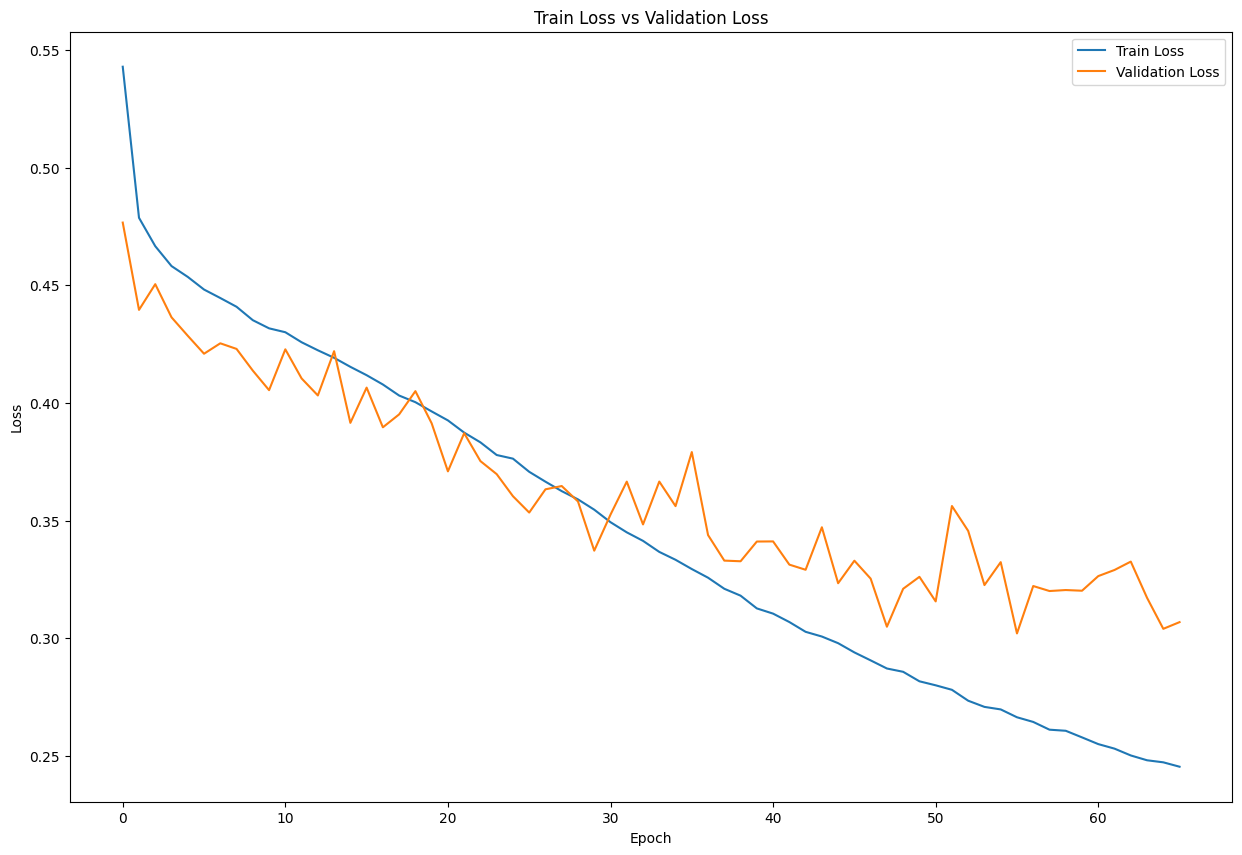

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [22]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tf.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_37372\2047877440.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tf

<All keys matched successfully>

In [23]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [24]:
model.eval()
preds = []
preds_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        preds.append(outputs.cpu().numpy())
        preds_targets.append(targets.cpu().numpy())
        
preds = np.concatenate(preds)
preds_targets = np.concatenate(preds_targets)

target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
all_targets = target_scaler.inverse_transform(preds_targets.reshape(-1, 1)).flatten()

residuals = all_preds - all_targets

Evaluation: 100%|██████████| 139/139 [00:01<00:00, 88.60it/s]


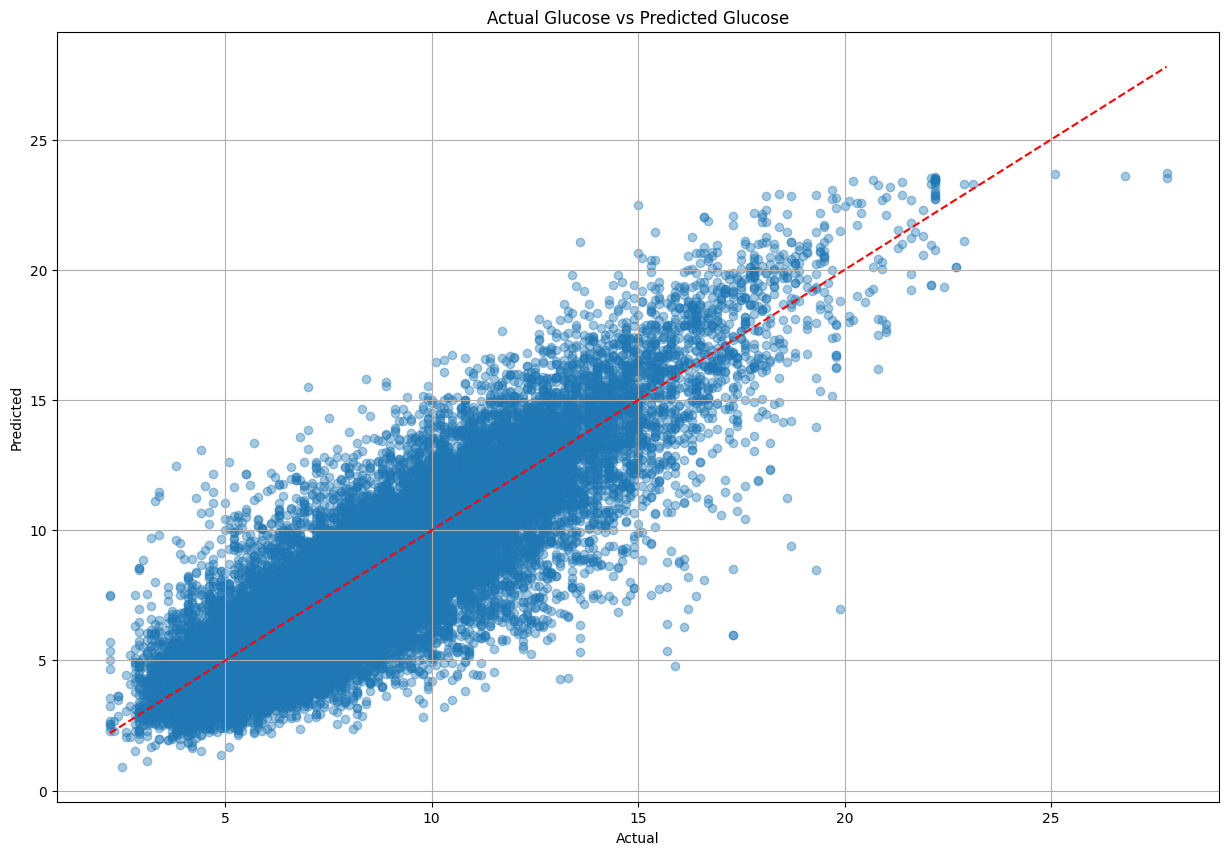

In [25]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

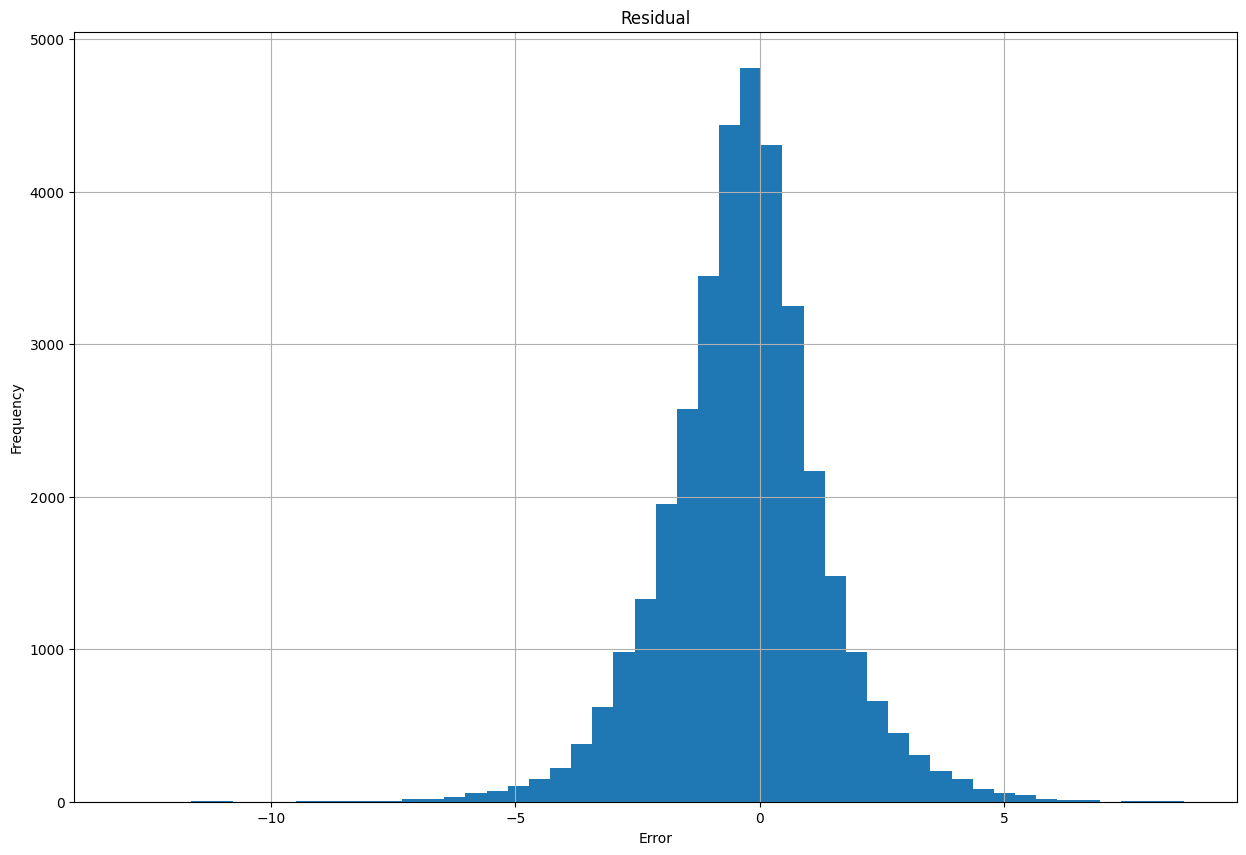

In [26]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [28]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [29]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [30]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MSE: {test_rmse**2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.6569
Test MSE: 2.7453
Test MAE: 1.2314
Test MARD: 0.1559
Test MBE: -0.3141
Test R²: 0.6908
Test Explained Variance: 0.7019
Test MAPE: 15.59%
Test CCC: 0.8604


### Inference

In [31]:
df_test = pd.read_csv("./.data/test_aug.csv")

In [32]:
print(df_test)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

In [33]:
for col in df_test.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

In [34]:
meta_data = ['id']
df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [35]:
infer_test_dataset = BrisT1DDataset(df_test, is_train=False)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=256, shuffle=False)

In [36]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tf.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_37372\2047877440.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tf

<All keys matched successfully>

In [37]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)

Inference: 100%|██████████| 15/15 [00:00<00:00, 111.99it/s]


In [38]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds_original = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

df_predictions = pd.DataFrame(all_preds_original, columns=["bg+1:00"])
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_aug_tf.csv", index=False)

### Submission

In [39]:
!kaggle competitions submit -c brist1d -f ./.export/test_submission_aug_tf.csv -m "BrisT1D Submission: Transformer"

Successfully submitted to BrisT1D Blood Glucose Prediction Competition



  0%|          | 0.00/68.0k [00:00<?, ?B/s]
100%|██████████| 68.0k/68.0k [00:00<00:00, 78.8kB/s]


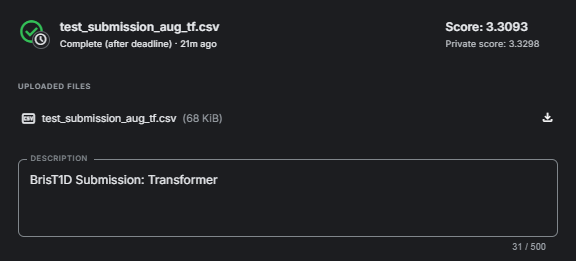

In [40]:
display(Image(filename='./.export/test_submission_aug_tf.png'))